### 使用KD树为空间数据建立索引结构


In [1]:
from collections import namedtuple
from operator import itemgetter
from pprint import pformat

class Node(namedtuple('Node', 'location left_child right_child')):
    """节点定义"""
    def __repr__(self):
#         t = tuple(self)
#         return pformat((('根节点:', t[0]), 
#                         ('左子树:', t[1]), 
#                         ('右子树:', t[2])))
        return pformat(tuple(self))

def kdtree(point_list, depth: int = 0):
    """建树"""
    if not point_list:
        return None
    
    # 确定分割维度
    k = len(point_list[0])
    axis = depth % k

    # 按照选定维度的值排序，并获取中间索引
    point_list.sort(key=itemgetter(axis))
    median = len(point_list) // 2

    # 以中间为根递归建立kd树
    return Node(
        location=point_list[median],
        left_child=kdtree(point_list[:median], depth + 1),
        right_child=kdtree(point_list[median + 1:], depth + 1)
    )

In [2]:
point_list = [(7,2), (5,4), (9,6), (4,7), (8,1), (2,3)]
tree = kdtree(point_list)
print(tree)

((7, 2),
 ((5, 4), ((2, 3), None, None), ((4, 7), None, None)),
 ((9, 6), ((8, 1), None, None), None))


![](1.png)
例：目标点$(2,4.1)$，3-近邻$(2, 3),(5, 4),(4, 7)$

In [3]:
import sys

maxint = sys.maxsize
minint = -maxint - 1
hr_max = [(minint, maxint), (minint, maxint)]
dist_max = float('inf')

search_steps = 0

In [4]:
def search_kdtree(tree, target_point, result, hr=hr_max, depth=0, text=True):
    """查找近邻"""
    global search_steps
    if depth == 0:
        search_steps = 1
    else:
        search_steps += 1

    cur_node = tree.location
    left_branch = tree.left_child
    right_branch = tree.right_child

    nearer_kd = farther_kd = None
    nearer_hr = farther_hr = None

    # 选择分割维度 —— 0/1交替
    axis = depth % 2

    # 依据axis分割平面
    left_hr, right_hr = split_hyperplane(cur_node, hr, axis)

    # 检查目标点处于哪个区域
    if target_point[axis] <= cur_node[axis]:
        nearer_kd = left_branch
        farther_kd = right_branch
        nearer_hr = left_hr
        farther_hr = right_hr
    else:
        nearer_kd = right_branch
        farther_kd = left_branch
        nearer_hr = right_hr
        farther_hr = left_hr

    # 检查当前点到NNs的距离是否更小
    dist = result.compute_rel_distance(cur_node, target_point)
    new_result = result.update(dist, cur_node)
    
    # nearer_kd是最近的子树，nearer_hr是对应的区域，进一步搜索这个区域
    if nearer_kd:
        if text:
            print("@当前:", cur_node, hr, 
                  "\n递归近邻:", nearer_kd.location, nearer_hr, '\n')
        search_kdtree(nearer_kd, target_point,
                      new_result, nearer_hr, depth+1, text)

    # 如果在另一半区域内还有点，
    # 那么在另一半区域可能会存在近邻，则需要计算目标点到另一个区域的最近距离
    if farther_kd:
        if text:
            print("@当前:", cur_node, hr, 
                  "\n回溯另一半:", farther_kd.location, farther_hr, '\n')
        # pt是farther_hr区域上距离目标点最近的点（理想点）
        pt = compute_closest_point(target_point, farther_hr)

        # 检查
        dist = new_result.compute_rel_distance( pt, target_point)
        if new_result.can_contain(dist):
            # 如果目标点到区域上理想点的距离比暂存的某个距离要小
            # 那么这个区域有望出现近邻点，搜索这个区域
            new_result = search_kdtree(farther_kd, target_point, 
                                       new_result, farther_hr, depth+1, text)
            
    return new_result

In [5]:
def split_hyperplane (point, hr, axis):
#     print("分割区域: X{},Y{}".format(hr[0], hr[1]))
#     print("以{}为分割点，".format(point), end='')
    if axis == 0:
#         print("分割X轴")
        left_hr  = [(hr[0][0], point[0]), hr[1]]
        right_hr = [(point[0], hr[0][1]), hr[1]]
        
    elif axis == 1:
#         print("分割Y轴")
        left_hr  = [hr[0], (hr[1][0], point[1])]
        right_hr = [hr[0], (point[1], hr[1][1])]
#     print("左/下半区域: X{},Y{}".format(left_hr[0], left_hr[1])) 
#     print("右/上半区域: X{},Y{}\n".format(right_hr[0], right_hr[1])) 
    return left_hr, right_hr

In [6]:
def compute_closest_coordinate(value, range_min, range_max):
    if value <= range_min:      #  X  <------->
        return range_min        #     ^
    elif value >= range_max:    #  <-------->  X
        return range_max        #           ^
    else:                       #    <------X--->
        return value            #           ^
    
def compute_closest_point(location, hr):
    """计算区域上距离目标最近的点"""
    return (compute_closest_coordinate(location[0], hr[0][0], hr[0][1]),
            compute_closest_coordinate(location[1], hr[1][0], hr[1][1]))

In [7]:
from sortedcontainers import SortedList

class NNeighborsResult:
    """knn的结果"""
    def __init__(self, n):
        self.n = n
        # n = 3
        self.list = SortedList(None,key=itemgetter(0))
        # [(1.2, (2, 3)), (9.01, (5, 4)), (12.4, (4, 7))]
        self.dist_max = float('inf')
        
    def can_contain(self, rel_dist):
        return rel_dist < self.dist_max  
        
    def update(self, dist, loc):
        # 更新list和dist_max
        if len(self.list) < self.n:
            # list未满
            self.list.add((dist, loc))
            if dist > self.dist_max:
                self.dist_max = dist
                
        elif dist < self.dist_max:
            # list已满，则检查dist_max
            self.list.add((dist, loc))
            self.list.pop(self.n)
            self.dist_max = self.list[self.n-1][0]
            
        return self

    def compute_rel_distance(self, loc_a, loc_b):
        return (loc_a[0] - loc_b[0])**2 + (loc_a[1] - loc_b[1])**2

In [8]:
result = search_kdtree(tree, (2,4.1), NNeighborsResult(3))
print(result.list)

@当前: (7, 2) [(-9223372036854775808, 9223372036854775807), (-9223372036854775808, 9223372036854775807)] 
递归近邻: (5, 4) [(-9223372036854775808, 7), (-9223372036854775808, 9223372036854775807)] 

@当前: (5, 4) [(-9223372036854775808, 7), (-9223372036854775808, 9223372036854775807)] 
递归近邻: (4, 7) [(-9223372036854775808, 7), (4, 9223372036854775807)] 

@当前: (5, 4) [(-9223372036854775808, 7), (-9223372036854775808, 9223372036854775807)] 
回溯另一半: (2, 3) [(-9223372036854775808, 7), (-9223372036854775808, 4)] 

@当前: (7, 2) [(-9223372036854775808, 9223372036854775807), (-9223372036854775808, 9223372036854775807)] 
回溯另一半: (9, 6) [(7, 9223372036854775807), (-9223372036854775808, 9223372036854775807)] 

SortedKeyList([(1.2099999999999993, (2, 3)), (9.01, (5, 4)), (12.410000000000002, (4, 7))], key=operator.itemgetter(0))


![](1.png)
例：目标点$(2,4.1)$，3-近邻$(2, 3),(5, 4),(4, 7)$

In [15]:
import pandas as pd 
df = pd.read_csv("CA/real.txt", header=None, sep=' ')

data = df.iloc[:, 6:]
data = [tuple(data.iloc[i]) for i in range(data.shape[0])]
# print(data)

In [16]:
print(data[:5])

[(-118.568, 34.1364), (-121.65, 37.4441), (-120.054, 38.8609), (-121.49799999999999, 38.6132), (-121.979, 37.2261)]


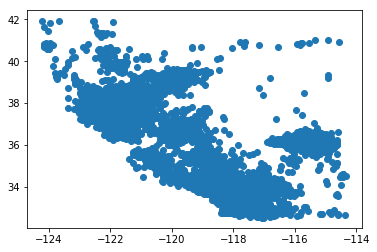

共有 22227 个数据点


In [17]:
import matplotlib.pyplot as plt
n = len(data)
x = [d[0] for d in data]
y = [d[1] for d in data]
plt.scatter(x, y)
plt.show()
print("共有", n, "个数据点") 

In [18]:
# 建树
%time tree = kdtree(data)
# print(tree)

Wall time: 295 ms


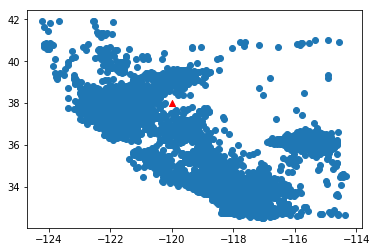

In [20]:
import random
tar = (-120, 38)
search_steps = 0
plt.scatter(x, y)
plt.scatter([tar[0]], [tar[1]], c='r', marker='^')

In [21]:
# 检索tar的10近邻
%time result = search_kdtree(tree, tar, NNeighborsResult(10), text=False)

Wall time: 2 ms


In [22]:
res = [r[1] for r in result.list]
print("结果：", res) 
print("调用search_kdtree函数", search_steps, "次")

结果： [(-120.22, 38.0104), (-120.262, 37.9633), (-119.854, 37.6807), (-120.376, 37.9608), (-119.81200000000001, 38.3643), (-119.932, 37.5647), (-120.375, 38.2348), (-119.821, 37.5726), (-119.625, 37.7178), (-120.398, 37.7486)]
调用search_kdtree函数 138 次


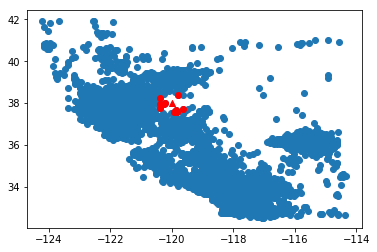

In [23]:
x_ = [d[0] for d in res]
y_ = [d[1] for d in res]
plt.scatter(x, y)
plt.scatter([tar[0]], [tar[1]], c='r', marker='^', )
plt.scatter(x_, y_, c='r')

Wall time: 7 ms
调用search_kdtree函数 486 次


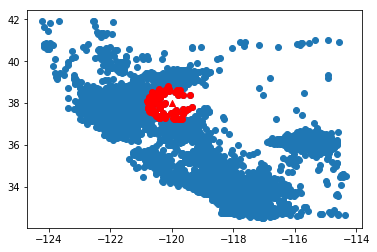

In [24]:
# 检索tar的100近邻
%time result = search_kdtree(tree, tar, NNeighborsResult(100), text=False)
print("调用search_kdtree函数", search_steps, "次")
res = [r[1] for r in result.list]
x_ = [d[0] for d in res]
y_ = [d[1] for d in res]
plt.scatter(x, y)
plt.scatter([tar[0]], [tar[1]], c='r', marker='^', )
plt.scatter(x_, y_, c='r')